<a href="https://colab.research.google.com/github/mercury0925/AI_study/blob/main/Transfer_Learning_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Computer Vision

**ResNet18 모델을 기반으로 위 두 가지 전이 학습 기법을 적용하여 개미(Ants)와 벌(Bees) 이미지를 정확하게 분류하는 모델을 구축**

**전이 학습(Transfer Learning)이란?**

실무에서 충분한 크기의 데이터셋을 확보하는 것은 매우 드물기 때문에, 무작위 초기화(Random Initialization)를 통해 처음부터 전체 네트워크를 학습시키는 경우는 거의 없다. 대신, ImageNet(1,000개 범주, 120만 장의 이미지)과 같은 거대한 데이터셋에서 미리 학습된 모델(Pretrained Model)을 가져와 사용한다.

이렇게 미리 학습된 모델을 목적에 맞게 활용하는 방식에는 크게 두 가지 시나리오가 있다

**미세 조정 (Finetuning the ConvNet)**: 네트워크를 무작위로 초기화하는 대신, ImageNet 등으로 미리 학습된 네트워크의 가중치를 초기값으로 사용. 이후 전체 네트워크를 새로운 데이터셋에 맞춰 다시 학습시킴

**고정된 특징 추출기 (ConvNet as fixed feature extractor)**: 마지막 출력층(Fully Connected Layer)을 제외한 모든 네트워크의 가중치를 고정(Freeze). 그 다음 마지막 층만 무작위 가중치를 가진 새로운 층으로 교체하고, 오직 이 마지막 층만 학습시킴.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

**데이터 로드 (Load Data)**
데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용

해결할 문제는 **개미(ants)**와 **벌(bees)**을 분류하도록 모델을 학습시키는 것. 개미와 벌 각각 약 120장의 학습용 이미지가 있으며, 각 클래스당 75장의 검증용 이미지가 준비되어 있음.

일반적으로 이 정도 양의 데이터는 처음부터(from scratch) 학습시켜 일반화 성능을 얻기에는 매우 적은 수치이다. 하지만 우리는 **전이 학습(Transfer Learning)**을 사용하기 때문에, 이 정도의 적은 데이터로도 상당히 괜찮은 일반화 성능을 얻을 수 있다.

In [3]:
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# Unzip the dataset if it's not already unzipped
data_dir = 'hymenoptera_data'
if not os.path.exists(data_dir):
    with zipfile.ZipFile('hymenoptera_data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**1. 데이터 시각화 (Visualize a few images)**

데이터 증강(Data Augmentation)이 어떻게 적용되었는지 이해하기 위해 학습용 이미지 중 몇 장을 시각화하여 확인해 본다.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


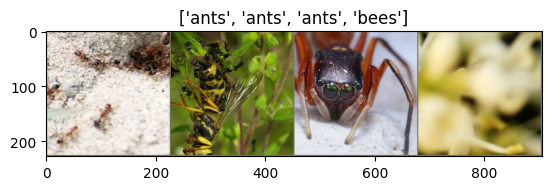

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**2. 모델 학습 (Training the model)**

이제 모델 학습을 위한 범용 함수를 작성해 보자. 이 과정에서 다음 내용들을 다룬다

학습률 스케줄링(Learning Rate Scheduling): 학습 과정에 따라 학습률을 조절하는 방법

최적의 모델 저장(Saving the best model): 검증 정확도가 가장 높은 시점의 모델을 보존하는 방법

아래 코드에서 scheduler 매개변수는 torch.optim.lr_scheduler에서 제공하는 학습률 스케줄러 객체를 의미

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

**3. 모델 예측 결과 시각화 (Visualizing the model predictions)**
학습된 모델이 이미지를 어떻게 예측하는지 확인하기 위해, 몇 가지 이미지에 대한 예측 결과를 표시하는 범용 함수를 작성한다

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**4. 모델 미세 조정 (Finetuning the ConvNet)**

합성곱 신경망 미세 조정(Finetuning) 사전 학습된 모델을 불러온 후, 마지막의 출력층(Fully Connected Layer)을 우리의 데이터(개미/벌)에 맞게 초기화한다

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 63.2MB/s]


**5. 학습 및 평가 (Train and evaluate)**

학습 및 평가 모델 학습을 시작한다. CPU 환경에서는 약 15~25분 정도 소요되지만, GPU 환경에서는 1분 내외로 빠르게 완료된다.

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6973 Acc: 0.6475
val Loss: 0.1202 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.3700 Acc: 0.8402
val Loss: 0.3312 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5150 Acc: 0.7951
val Loss: 0.3110 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4680 Acc: 0.7992
val Loss: 0.3092 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4725 Acc: 0.8074
val Loss: 0.4667 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.5308 Acc: 0.8156
val Loss: 0.2210 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3072 Acc: 0.8811
val Loss: 0.3081 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4541 Acc: 0.8238
val Loss: 0.2533 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.2941 Acc: 0.8893
val Loss: 0.2232 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3054 Acc: 0.8607
val Loss: 0.2031 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2927 Acc: 0.8730
val Loss: 0.1948 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2942 Acc: 0.8770
val Loss: 0.1943 Acc: 0.9216

Ep

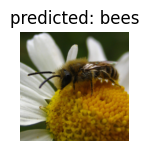

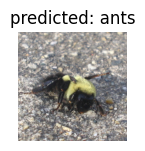

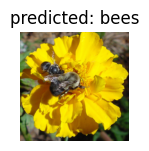

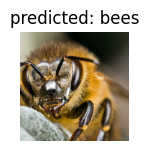

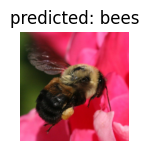

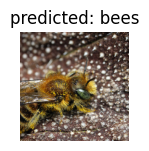

In [9]:
visualize_model(model_ft)

**6. 고정 특징 추출기로서의 신경망 (ConvNet as fixed feature extractor)**
이 시나리오에서는 마지막 출력층을 제외한 네트워크의 모든 매개변수를 고정(Freeze)한다. requires_grad = False를 설정하여 역전파(Backward) 단계에서 그래디언트가 계산되지 않도록 함으로써 학습 시간을 단축하고, 사전 학습된 특징을 그대로 유지한다

In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**7. 학습 및 평가 (Train and evaluate)**
이 시나리오는 대부분의 네트워크에서 그래디언트(Gradient)를 계산할 필요가 없기 때문에, 이전 시나리오에 비해 CPU 기준 학습 시간이 절반 정도로 단축된다. 이는 예상된 결과이며, 다만 순전파(Forward) 과정은 여전히 계산되어야 한다.

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6222 Acc: 0.6762
val Loss: 0.2907 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5927 Acc: 0.7500
val Loss: 0.2180 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5834 Acc: 0.7377
val Loss: 0.3344 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.6486 Acc: 0.7459
val Loss: 0.2153 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5126 Acc: 0.7582
val Loss: 0.4378 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4595 Acc: 0.7910
val Loss: 0.2766 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6122 Acc: 0.7746
val Loss: 0.1716 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4364 Acc: 0.8238
val Loss: 0.2108 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3709 Acc: 0.8197
val Loss: 0.1630 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3648 Acc: 0.8361
val Loss: 0.1640 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3578 Acc: 0.8361
val Loss: 0.1726 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3127 Acc: 0.8566
val Loss: 0.1668 Acc: 0.9477

Ep

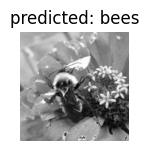

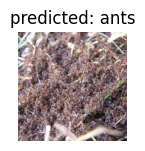

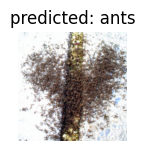

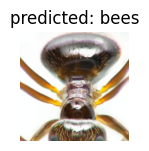

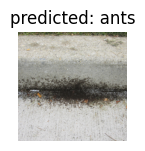

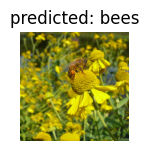

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

**8. 사용자 지정 이미지 추론 (Inference on custom images)**

사용자 지정 이미지 추론 학습된 모델을 사용하여 새로운 이미지에 대한 예측을 수행하고, 예측된 클래스 레이블(개미/벌)을 이미지와 함께 시각화하여 모델의 성능을 확인해 보자

In [13]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

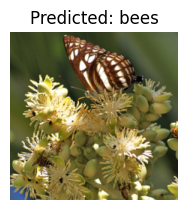

In [15]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()